In [2]:
!unzip archive.zip -d emotions_data
!ls emotions_data

Archive:  archive.zip
  inflating: emotions_data/test.txt  
  inflating: emotions_data/train.txt  
  inflating: emotions_data/val.txt   
test.txt  train.txt  val.txt


# **Load the Data**

In [3]:
import pandas as pd

# Load train data
train_path = 'emotions_data/train.txt'
df_train = pd.read_csv(train_path, sep=';', header=None, names=['text', 'label'])

# Show first few rows
df_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df_train.isnull().sum()

,0
text,0
label,0


In [5]:
df_train.shape

(16000, 2)

# **Visualize Label Distribution**

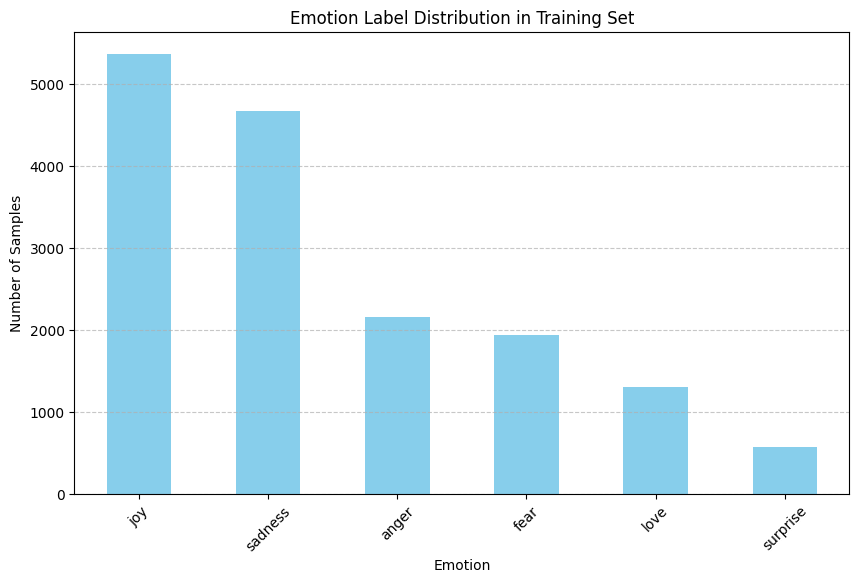

In [6]:
import matplotlib.pyplot as plt

label_counts = df_train['label'].value_counts()

plt.figure(figsize=(10,6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Label Distribution in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Preprocess the Data (Label Encoding + Train/Test/Val Sets)**

In [7]:
from sklearn.preprocessing import LabelEncoder

# Load other splits
df_val = pd.read_csv('emotions_data/val.txt', sep=';', header=None, names=['text', 'label'])
df_test = pd.read_csv('emotions_data/test.txt', sep=';', header=None, names=['text', 'label'])

# Combine all to create consistent encoding
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']])

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode each set
df_train['label_encoded'] = label_encoder.transform(df_train['label'])
df_val['label_encoded'] = label_encoder.transform(df_val['label'])
df_test['label_encoded'] = label_encoder.transform(df_test['label'])

# Check mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'anger': np.int64(0), 'fear': np.int64(1), 'joy': np.int64(2), 'love': np.int64(3), 'sadness': np.int64(4), 'surprise': np.int64(5)}


In [8]:
df_val.shape

(2000, 3)

In [9]:
df_test.shape

(2000, 3)

# **Building a baseline model - Logistic Regression**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
pipeline.fit(df_train['text'], df_train['label_encoded'])

# Validate
val_preds = pipeline.predict(df_val['text'])

# Evaluation
print("Validation Accuracy:", accuracy_score(df_val['label_encoded'], val_preds))
print("\nClassification Report:\n")
print(classification_report(df_val['label_encoded'], val_preds, target_names=label_encoder.classes_))

Validation Accuracy: 0.863

Classification Report:

              precision    recall  f1-score   support

       anger       0.91      0.82      0.87       275
        fear       0.85      0.75      0.80       212
         joy       0.85      0.94      0.89       704
        love       0.89      0.63      0.74       178
     sadness       0.86      0.94      0.90       550
    surprise       0.84      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000



In [11]:
# Define pipeline with class_weight='balanced'
pipeline_balanced = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train with balanced weights
pipeline_balanced.fit(df_train['text'], df_train['label_encoded'])

# Validate
val_preds_balanced = pipeline_balanced.predict(df_val['text'])

# Evaluation
print("Validation Accuracy (with balanced class weights):", accuracy_score(df_val['label_encoded'], val_preds_balanced))
print("\nClassification Report:\n")
print(classification_report(df_val['label_encoded'], val_preds_balanced, target_names=label_encoder.classes_))

Validation Accuracy (with balanced class weights): 0.889

Classification Report:

              precision    recall  f1-score   support

       anger       0.88      0.92      0.90       275
        fear       0.82      0.84      0.83       212
         joy       0.95      0.87      0.91       704
        love       0.76      0.95      0.84       178
     sadness       0.94      0.89      0.91       550
    surprise       0.73      0.91      0.81        81

    accuracy                           0.89      2000
   macro avg       0.84      0.90      0.87      2000
weighted avg       0.90      0.89      0.89      2000



# **Hyperparamter Tuning**

In [12]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'clf__penalty': ['l1', 'l2']  # Regularization type
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_balanced, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(df_train['text'], df_train['label_encoded'])

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model
val_preds_best = best_model.predict(df_val['text'])
print("Validation Accuracy (Best Model):", accuracy_score(df_val['label_encoded'], val_preds_best))
print("\nClassification Report:\n")
print(classification_report(df_val['label_encoded'], val_preds_best, target_names=label_encoder.classes_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Best parameters found:  {'clf__C': 10, 'clf__penalty': 'l2'}
Validation Accuracy (Best Model): 0.8925

Classification Report:

              precision    recall  f1-score   support

       anger       0.88      0.89      0.89       275
        fear       0.85      0.84      0.85       212
         joy       0.94      0.89      0.92       704
        love       0.77      0.91      0.84       178
     sadness       0.92      0.91      0.92       550
    surprise       0.76      0.85      0.80        81

    accuracy                           0.89      2000
   macro avg       0.85      0.88      0.87      2000
weighted avg       0.90      0.89      0.89      2000



In [13]:
!pip install transformers --upgrade

# **Introducing BERT for Emotion Detection**

In [14]:
import transformers
print(transformers.__version__)

4.51.3


In [15]:
from transformers import TrainingArguments
print(TrainingArguments)

<class 'transformers.training_args.TrainingArguments'>


In [16]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=256)

train_encodings = df_train['text'].apply(tokenize_function)
val_encodings = df_val['text'].apply(tokenize_function)
test_encodings = df_test['text'].apply(tokenize_function)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
from torch.utils.data import Dataset
import torch

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Convert label to numerical value using label_encoder if it's a string
        label = self.labels[idx]
        if isinstance(label, str):  # Check if the label is a string
            label = label_encoder.transform([label])[0]  # Encode the label using your label_encoder

        item["labels"] = torch.tensor(label)
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_encodings = tokenizer(df_train['text'].tolist(), padding=True, truncation=True, max_length=256)
val_encodings = tokenizer(df_val['text'].tolist(), padding=True, truncation=True, max_length=256)

In [19]:
train_labels = df_train['label'].tolist()
val_labels = df_val['label'].tolist()

In [20]:
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)

In [21]:
from transformers import BertForSequenceClassification

# Load the BERT model for text classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [24]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.240200,0.216261,0.930500,0.931226,0.934247,0.930500
2,0.064300,0.166941,0.938500,0.938228,0.939204,0.938500
3,0.161200,0.190530,0.937000,0.936627,0.937095,0.937000


TrainOutput(global_step=6000, training_loss=0.23295013328144948, metrics={'train_runtime': 997.6405, 'train_samples_per_second': 48.114, 'train_steps_per_second': 6.014, 'total_flos': 2146076617536000.0, 'train_loss': 0.23295013328144948, 'epoch': 3.0})

In [25]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()

print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.16694125533103943, 'eval_accuracy': 0.9385, 'eval_f1': 0.9382278079251474, 'eval_precision': 0.9392040630334363, 'eval_recall': 0.9385, 'eval_runtime': 8.4555, 'eval_samples_per_second': 236.533, 'eval_steps_per_second': 14.783, 'epoch': 3.0}


In [27]:
test_encodings = tokenizer(df_test['text'].tolist(), padding=True, truncation=True, max_length=256)

In [28]:
test_labels = df_test['label'].tolist()
test_dataset = EmotionDataset(test_encodings, test_labels)

test_results = trainer.evaluate(test_dataset)
print("Test Evaluation Results:", test_results)


Test Evaluation Results: {'eval_loss': 0.1837129145860672, 'eval_accuracy': 0.932, 'eval_f1': 0.9311387433885286, 'eval_precision': 0.9322896939442664, 'eval_recall': 0.932, 'eval_runtime': 7.5655, 'eval_samples_per_second': 264.358, 'eval_steps_per_second': 16.522, 'epoch': 3.0}


              precision    recall  f1-score   support

       anger       0.95      0.89      0.92       275
        fear       0.88      0.94      0.91       224
         joy       0.94      0.97      0.95       695
        love       0.92      0.75      0.82       159
     sadness       0.96      0.97      0.97       581
    surprise       0.75      0.76      0.75        66

    accuracy                           0.93      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.93      0.93      0.93      2000



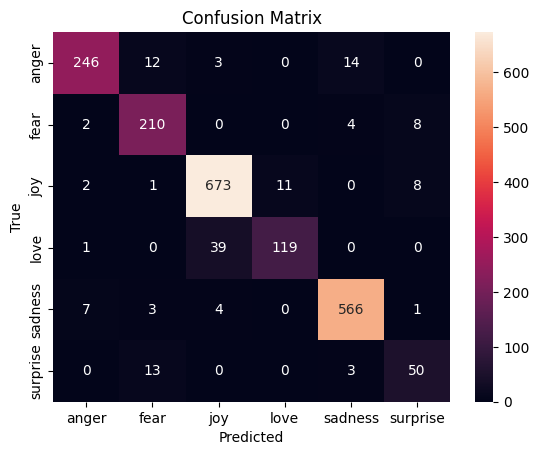

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Convert numerical predictions back to original labels
preds_labels = label_encoder.inverse_transform(preds)

# Classification report
print(classification_report(test_labels, preds_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, preds_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json')

In [36]:
# import pandas as pd
# from datetime import datetime, timedelta
# import random

# # Sample list of users (You can replace this with real user IDs later)
# users = ['user_01', 'user_02', 'user_03', 'user_04']

# # Sample emotions (These would be the predicted emotions from your BERT model)
# emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

# # Simulating some texts (these would typically come from users' journals)
# texts = [
#     "I feel so anxious today",
#     "Such a great day, everything went well!",
#     "I am feeling a bit down",
#     "Life is beautiful!",
#     "Feeling sad and stressed out",
#     "What a surprising turn of events!"
# ]

# # Initialize an empty list to store the logs
# logs = []

# # Generate logs for the last 7 days (simulate a week's worth of emotion logs for each user)
# for user in users:
#     # Generate logs for 7 days for each user
#     for i in range(7):
#         # Simulate a timestamp for each log entry (starting from today)
#         timestamp = datetime.now() - timedelta(days=i)

#         # Pick a random emotion and corresponding text
#         emotion = random.choice(emotions)
#         text = random.choice(texts)

#         # Append the log entry (user, timestamp, text, emotion)
#         logs.append({
#             'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
#             'user_id': user,
#             'text': text,
#             'predicted_emotion': emotion
#         })

# # Create a DataFrame to store the emotion logs
# emotion_log_df = pd.DataFrame(logs)

# # Display the emotion log DataFrame
# print(emotion_log_df)

# **Tracking Emotions Over Time**

In [35]:
import torch

# Function to get model predictions for a given text
def get_emotion_prediction(text, model, tokenizer):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)

    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get the model's device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict the emotion using the model
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()  # Get the predicted class index
    return predicted_class

# Initialize an empty list to store the logs
logs = []

# Simulate logs for the last 7 days (for each user)
for user in users:
    for i in range(7):
        timestamp = datetime.now() - timedelta(days=i)

        # Pick a random text
        text = random.choice(texts)

        # Get the model's predicted emotion for the text
        predicted_emotion_idx = get_emotion_prediction(text, model, tokenizer)
        predicted_emotion = label_encoder.inverse_transform([predicted_emotion_idx])[0]

        # Append the log entry (timestamp, user, text, predicted_emotion)
        logs.append({
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'user_id': user,
            'text': text,
            'predicted_emotion': predicted_emotion
        })

# Create a DataFrame to store the emotion logs
emotion_log_df = pd.DataFrame(logs)

# Display the emotion log DataFrame
print(emotion_log_df)

              timestamp  user_id                                     text  \
0   2025-05-02 20:25:51  user_01                       Life is beautiful!   
1   2025-05-01 20:25:51  user_01                  I feel so anxious today   
2   2025-04-30 20:25:51  user_01             Feeling sad and stressed out   
3   2025-04-29 20:25:51  user_01                  I am feeling a bit down   
4   2025-04-28 20:25:51  user_01        What a surprising turn of events!   
5   2025-04-27 20:25:51  user_01             Feeling sad and stressed out   
6   2025-04-26 20:25:51  user_01                  I am feeling a bit down   
7   2025-05-02 20:25:51  user_02             Feeling sad and stressed out   
8   2025-05-01 20:25:51  user_02  Such a great day, everything went well!   
9   2025-04-30 20:25:51  user_02        What a surprising turn of events!   
10  2025-04-29 20:25:51  user_02                  I feel so anxious today   
11  2025-04-28 20:25:51  user_02                  I feel so anxious today   

# **Analyzing Emotional Trends**

   user_id   timestamp predicted_emotion  count
0  user_01  2025-04-26           sadness      1
1  user_01  2025-04-27           sadness      1
2  user_01  2025-04-28          surprise      1
3  user_01  2025-04-29           sadness      1
4  user_01  2025-04-30           sadness      1
    user_id   timestamp predicted_emotion  count
0   user_01  2025-04-26           sadness      1
1   user_01  2025-04-27           sadness      1
2   user_01  2025-04-28          surprise      1
3   user_01  2025-04-29           sadness      1
4   user_01  2025-04-30           sadness      1
5   user_01  2025-05-01              fear      1
6   user_01  2025-05-02               joy      1
7   user_02  2025-04-26               joy      1
8   user_02  2025-04-27          surprise      1
9   user_02  2025-04-28              fear      1
10  user_02  2025-04-29              fear      1
11  user_02  2025-04-30          surprise      1
12  user_02  2025-05-01               joy      1
13  user_02  2025-05-02   

<ipython-input-43-3b0895306de9>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_analysis = emotion_counts.groupby(['user_id', 'timestamp']).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)


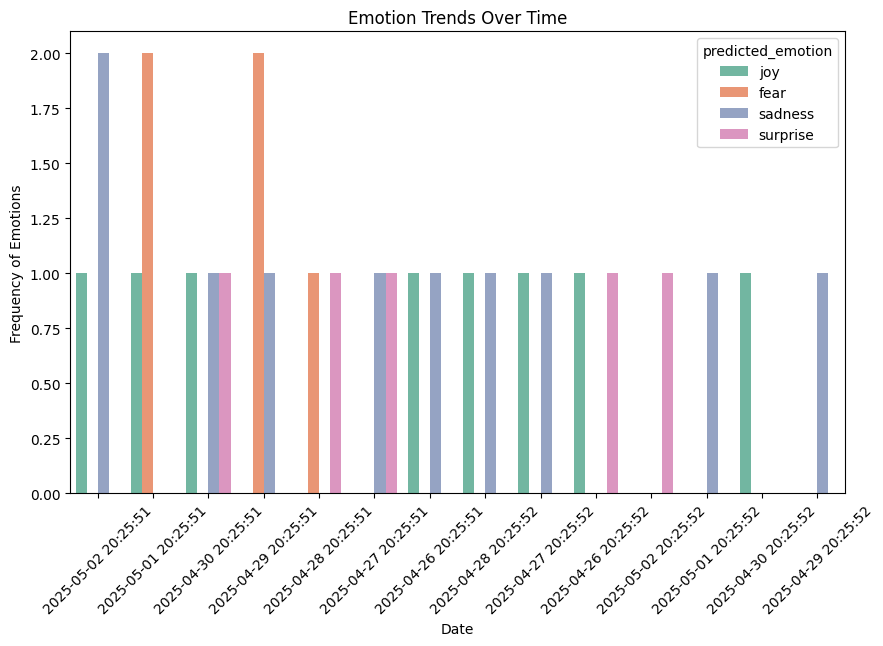

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'emotion_log_df' is the dataframe from the previous step

# Convert 'timestamp' column to datetime format for easier manipulation
emotion_log_df['timestamp'] = pd.to_datetime(emotion_log_df['timestamp'])

# Group by user_id and date to get the frequency of each emotion per day
emotion_counts = emotion_log_df.groupby([emotion_log_df['user_id'], emotion_log_df['timestamp'].dt.date, 'predicted_emotion']).size().reset_index(name='count')

# Display the first few rows of the grouped data
print(emotion_counts.head())

# Analyze the trends
# For each user, find the most frequent emotions for each day
trend_analysis = emotion_counts.groupby(['user_id', 'timestamp']).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)


# Show the trend analysis result
print(trend_analysis)

# If you'd like to visualize these trends (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=emotion_log_df, x='timestamp', hue='predicted_emotion', palette='Set2')

plt.title("Emotion Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Frequency of Emotions")
plt.xticks(rotation=45)
plt.show()


# **Simple Personalization**

In [44]:
# Function to generate custom summaries and suggest interventions
def generate_personalized_summary(user_id, emotion_log_df):
    # Filter the user's logs
    user_logs = emotion_log_df[emotion_log_df['user_id'] == user_id]

    # Identify trends in emotions (e.g., how many days of sadness, joy, etc.)
    emotion_counts = user_logs['predicted_emotion'].value_counts()

    # Check for long-term low moods (e.g., sadness or fear for multiple days)
    low_moods = ['sadness', 'fear']
    long_term_low_mood = emotion_counts[emotion_counts.index.isin(low_moods)]

    # Check if there's a significant low mood trend (e.g., 3 or more consecutive days of sadness)
    low_mood_days = user_logs[user_logs['predicted_emotion'].isin(low_moods)]
    consecutive_low_moods = low_mood_days['predicted_emotion'].value_counts()

    # Generate summary and suggestion
    if len(low_mood_days) >= 3:
        summary = f"You've been feeling low for {len(low_mood_days)} days."
        intervention = "We suggest journaling today or taking a few minutes to meditate or breathe deeply."
    else:
        summary = f"You’ve been feeling positive for {len(user_logs) - len(low_mood_days)} days."
        intervention = "Keep up the positive vibes! Consider sharing your good mood with a friend today."

    return summary, intervention

# Loop through users to generate summaries and interventions
for user in emotion_log_df['user_id'].unique():
    summary, intervention = generate_personalized_summary(user, emotion_log_df)

    # Display the summary and suggestion
    print(f"User {user}:")
    print(f"  Summary: {summary}")
    print(f"  Intervention Suggestion: {intervention}\n")


User user_01:
  Summary: You've been feeling low for 5 days.
  Intervention Suggestion: We suggest journaling today or taking a few minutes to meditate or breathe deeply.

User user_02:
  Summary: You've been feeling low for 3 days.
  Intervention Suggestion: We suggest journaling today or taking a few minutes to meditate or breathe deeply.

User user_03:
  Summary: You've been feeling low for 4 days.
  Intervention Suggestion: We suggest journaling today or taking a few minutes to meditate or breathe deeply.

User user_04:
  Summary: You've been feeling low for 3 days.
  Intervention Suggestion: We suggest journaling today or taking a few minutes to meditate or breathe deeply.



In [47]:
# Enhance features: include previous emotion and emotional trends
emotion_log_df['prev_emotion'] = emotion_log_df.groupby('user_id')['predicted_emotion'].shift(1)

# Count how many times each emotion appeared in the last 7 days
emotion_log_df['emotion_count'] = emotion_log_df.groupby(['user_id', 'predicted_emotion'])['predicted_emotion'].transform('count')

# For simplicity, let's assume we're now using 'prev_emotion' and 'emotion_count' as features
emotion_log_df['prev_emotion_code'] = emotion_log_df['prev_emotion'].map({
    'joy': 0, 'sadness': 1, 'fear': 2, 'anger': 3, 'surprise': 4, 'love': 5
})
emotion_log_df['emotion_count'] = emotion_log_df['emotion_count'].astype(int)

# Train a model with these additional features
for user in emotion_log_df['user_id'].unique():
    user_data = emotion_log_df[emotion_log_df['user_id'] == user]

    # Use 'prev_emotion_code' and 'emotion_count' as features
    X = user_data[['prev_emotion_code', 'emotion_count']]
    y = user_data['emotion_code']

    # Handle missing data (drop rows with NaN values)
    X = X.dropna()
    y = y[X.index]  # Drop corresponding labels

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"User {user} Model Accuracy: {accuracy:.2f}")


User user_01 Model Accuracy: 0.50
User user_02 Model Accuracy: 0.50
User user_03 Model Accuracy: 0.50
User user_04 Model Accuracy: 1.00


# **Creating user-specific emotion profiles using embeddings**

In [48]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Load the same BERT model and tokenizer (used for fine-tuning)
bert_model = AutoModel.from_pretrained('bert-base-uncased')
bert_model.eval()
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Function to get sentence embedding (mean pooling of BERT output)
def get_sentence_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)
    embedding = last_hidden_state.mean(dim=0).numpy()
    return embedding

# Create user-specific emotion profile (mean embedding of their texts)
user_profiles = {}
for user in emotion_log_df['user_id'].unique():
    user_texts = emotion_log_df[emotion_log_df['user_id'] == user]['text']
    embeddings = [get_sentence_embedding(text, bert_model, tokenizer) for text in user_texts]
    avg_embedding = np.mean(embeddings, axis=0)
    user_profiles[user] = avg_embedding


# **Comparing new input text to user profile using cosine similarity**

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compare a new text with user's emotional profile
def compare_to_user_profile(user_id, text, user_profiles, model, tokenizer):
    new_embedding = get_sentence_embedding(text, model, tokenizer).reshape(1, -1)
    user_embedding = user_profiles[user_id].reshape(1, -1)
    similarity = cosine_similarity(new_embedding, user_embedding)[0][0]
    return similarity

# Example usage (for recent log entries)
for user in emotion_log_df['user_id'].unique():
    latest_text = emotion_log_df[emotion_log_df['user_id'] == user].iloc[-1]['text']
    sim_score = compare_to_user_profile(user, latest_text, user_profiles, bert_model, tokenizer)
    print(f"User: {user}, Similarity to Profile: {sim_score:.2f}")

User: user_01, Similarity to Profile: 0.88
User: user_02, Similarity to Profile: 0.89
User: user_03, Similarity to Profile: 0.83
User: user_04, Similarity to Profile: 0.87


# **Detect shifts and flag for intervention**

In [52]:
# Set a similarity threshold
SIMILARITY_THRESHOLD = 0.90

# Check for users showing emotional shift
alerts = []

for user in emotion_log_df['user_id'].unique():
    latest_text = emotion_log_df[emotion_log_df['user_id'] == user].iloc[-1]['text']
    sim_score = compare_to_user_profile(user, latest_text, user_profiles, bert_model, tokenizer)

    if sim_score < SIMILARITY_THRESHOLD:
        alerts.append({
            'user_id': user,
            'similarity': sim_score,
            'latest_text': latest_text,
            'flag': 'Potential emotional shift detected'
        })

# Show alerts
alerts_df = pd.DataFrame(alerts)
print(alerts_df)


   user_id  similarity                              latest_text  \
0  user_01    0.878674                  I am feeling a bit down   
1  user_02    0.890601  Such a great day, everything went well!   
2  user_03    0.831330                       Life is beautiful!   
3  user_04    0.872799        What a surprising turn of events!   

                                 flag  
0  Potential emotional shift detected  
1  Potential emotional shift detected  
2  Potential emotional shift detected  
3  Potential emotional shift detected  


# **Match similar emotional states and reuse helpful interventions**

In [53]:
# Simulate intervention log
intervention_logs = []

# Sample interventions
interventions = [
    "Try 10-minute meditation",
    "Write a short journal entry",
    "Talk to a close friend",
    "Do a short walk outdoors"
]

# Assume some alerts were triggered (simulated for demonstration)
simulated_alerts = [
    {"user_id": "user_01", "timestamp": "2025-05-02", "predicted_emotion": "sadness"},
    {"user_id": "user_03", "timestamp": "2025-05-02", "predicted_emotion": "fear"}
]

# Log the shown intervention and user feedback
for alert in simulated_alerts:
    suggested = random.choice(interventions)
    user_feedback = random.choice(["yes", "no"])  # simulate feedback

    intervention_logs.append({
        "user_id": alert["user_id"],
        "timestamp": alert["timestamp"],
        "predicted_emotion": alert["predicted_emotion"],
        "intervention": suggested,
        "was_helpful": user_feedback
    })

# Convert to DataFrame
intervention_df = pd.DataFrame(intervention_logs)
print(intervention_df)


   user_id   timestamp predicted_emotion                 intervention  \
0  user_01  2025-05-02           sadness     Try 10-minute meditation   
1  user_03  2025-05-02              fear  Write a short journal entry   

  was_helpful  
0         yes  
1         yes  


In [54]:
# Build a lookup from past helpful interventions
helpful_lookup = intervention_df[intervention_df["was_helpful"] == "yes"]

# Function to recommend based on similar past emotions
def recommend_intervention(user_id, current_emotion, lookup_df):
    # Check if we’ve seen this emotion before in helpful history
    similar_cases = lookup_df[lookup_df["predicted_emotion"] == current_emotion]

    if not similar_cases.empty:
        return similar_cases["intervention"].sample(1).values[0]  # random helpful one
    else:
        return "Explore something calming you enjoy"  # fallback

# Example usage
user_current_state = {
    "user_id": "user_03",
    "predicted_emotion": "fear"
}

suggested = recommend_intervention(
    user_current_state["user_id"],
    user_current_state["predicted_emotion"],
    helpful_lookup
)

print(f"Suggested intervention for {user_current_state['user_id']} (emotion: {user_current_state['predicted_emotion']}): {suggested}")


Suggested intervention for user_03 (emotion: fear): Write a short journal entry
